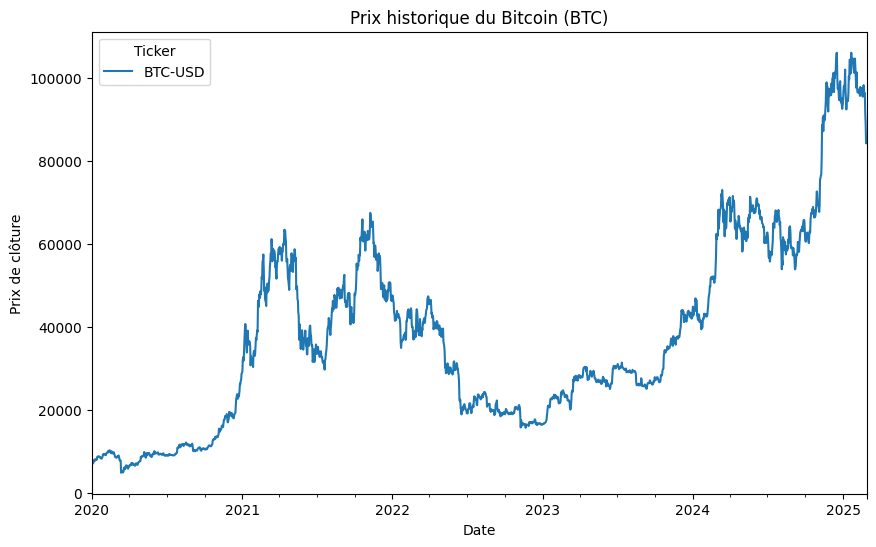

mean_return State
0    0.029098
1   -0.000054
2   -0.026474
Name: Return, dtype: float64
Matrice de Transition :
[[0.3772846  0.2075718  0.4151436 ]
 [0.36253041 0.30900243 0.32846715]
 [0.46327684 0.17655367 0.36016949]]


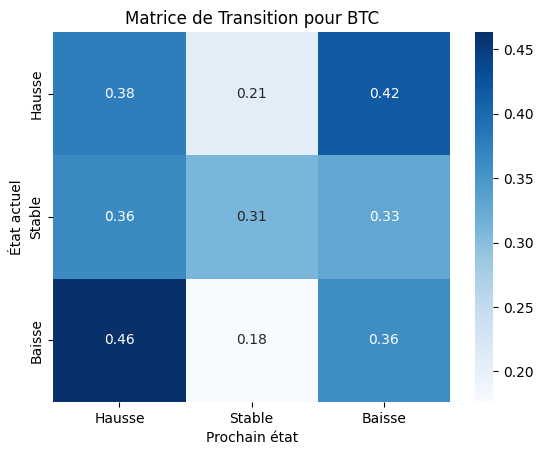

In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Étape 1 : Récupérer les données historiques de BTC
btc = yf.download("BTC-USD", start="2020-01-01", end="2025-03-01", progress=False)
btc['Close'].plot(figsize=(10,6))
plt.title("Prix historique du Bitcoin (BTC)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.show()

# Étape 2 : Calcul des rendements journaliers
btc['Return'] = btc['Close'].pct_change()  # Rendement journalier

# Étape 3 : Discrétisation des rendements en états
# Définir les seuils pour discrétiser les rendements en 3 états
# Hausse: Rendement > 0.5%, Stable: -0.5% <= Rendement <= 0.5%, Baisse: Rendement < -0.5%
def discretize_return(r):
    if r > 0.005:
        return 0  # Hausse
    elif r < -0.005:
        return 2  # Baisse
    else:
        return 1  # Stable

btc['State'] = btc['Return'].apply(discretize_return)

mean_return = btc.groupby('State')['Return'].mean()
print("mean_return", mean_return)

# Étape 4 : Calculer la matrice de transition
n_states = 3  # Hausse, stable, baisse
transition_matrix = np.zeros((n_states, n_states))

# Calculer les transitions entre états
for i in range(1, len(btc)):
    current_state = btc['State'].iloc[i-1]
    next_state = btc['State'].iloc[i]
    transition_matrix[current_state, next_state] += 1

# Normaliser les transitions pour obtenir les probabilités
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Afficher la matrice de transition
print("Matrice de Transition :")
print(transition_matrix)

# Affichage de la matrice de transition sous forme visuelle
import seaborn as sns
sns.heatmap(transition_matrix, annot=True, cmap="Blues", xticklabels=["Hausse", "Stable", "Baisse"], yticklabels=["Hausse", "Stable", "Baisse"])
plt.title("Matrice de Transition pour BTC")
plt.xlabel("Prochain état")
plt.ylabel("État actuel")
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_30912\2026905971.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  initial_price = int(btc['Close'].iloc[-1])  # Prix initial du BTC


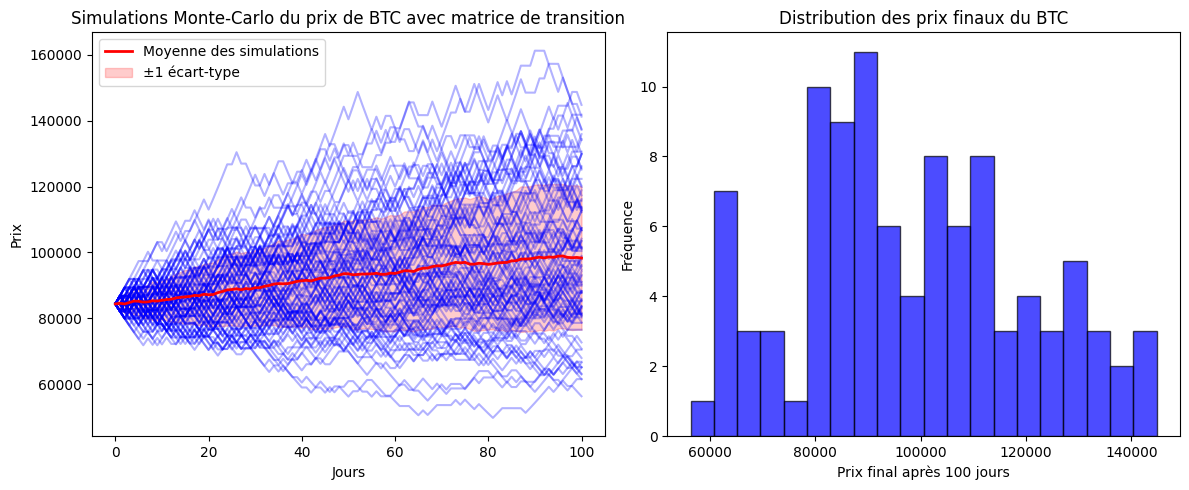

In [22]:
# Paramètres de simulation
n_simulations = 100  # Nombre de simulations
n_days = 100  # Nombre de jours simulés
initial_price = int(btc['Close'].iloc[-1])  # Prix initial du BTC

# États possibles et leurs effets sur le prix (en pourcentage)
state_prices = [1 + mean_return[0], 1 + mean_return[1], 1 + mean_return[2]] # Hausse, Stable, Baisse

# Stocker les trajectoires et les prix finaux
all_prices = []
final_prices = []

# Simulation Monte Carlo
for _ in range(n_simulations):
    price = initial_price
    state = np.random.choice([0, 1, 2])  # État initial aléatoire (0: Hausse, 1: Stable, 2: Baisse)
    prices = [price]

    for _ in range(n_days):
        price *= state_prices[state]  # Mise à jour du prix en fonction de l'état
        state = np.random.choice([0, 1, 2], p=transition_matrix[state])  # Transition basée sur la matrice de transition
        prices.append(price)

    all_prices.append(prices)  # On stocke la trajectoire complète
    final_prices.append(prices[-1])  # On stocke seulement le prix final

# Convertir en numpy array pour faciliter les calculs
all_prices = np.array(all_prices)

# Calcul de la moyenne et de l'écart-type à chaque jour
mean_prices = np.mean(all_prices, axis=0)
std_prices = np.std(all_prices, axis=0)

# Tracer les simulations et la moyenne
plt.figure(figsize=(12, 5))

# Graphique des trajectoires avec la moyenne
plt.subplot(1, 2, 1)
for prices in all_prices:
    plt.plot(prices, alpha=0.3, color="blue")  # Tracer chaque simulation

plt.plot(mean_prices, color="red", linewidth=2, label="Moyenne des simulations")
plt.fill_between(range(n_days + 1), mean_prices - std_prices, mean_prices + std_prices, color="red", alpha=0.2, label="±1 écart-type")

plt.xlabel("Jours")
plt.ylabel("Prix")
plt.title("Simulations Monte-Carlo du prix de BTC avec matrice de transition")
plt.legend()

# Histogramme des prix finaux
plt.subplot(1, 2, 2)
plt.hist(final_prices, bins=20, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Prix final après 100 jours")
plt.ylabel("Fréquence")
plt.title("Distribution des prix finaux du BTC")

plt.tight_layout()
plt.show()
